In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.lines as lin
import traceback

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

In [171]:
def relu(x):
    return np.maximum(x,0)
def grad_relu(x):
    return np.array(0 < x,dtype=float)
def grad_irelu(y):
    return np.array(0 < y,dtype=float)
def lrelu(x):
    ''' Leaky relu '''
    return np.maximum(x,0) + 0.1 * np.minimum(x,0)
def grad_ilrelu(y):
    ''' Gradient of leaky relu with respect to output '''
    return np.array(0 < y,dtype=float) - 0.1 * np.array(y < 0,dtype=float)
def ident(x):
    return x
def grad_iident(x):
    return 1.

In [3]:
def describe(a):
    return "%s, %s, %s" % (type(a), a.shape, a)

In [206]:
nn_debug = False
hidden_nodes = 64

def square_nn(x, y, THETA1, THETA2, it, init_w=0, learn=0, alpha=0.01, dropout=0):
    """ function to calculate and learn square solution """
    # first see if this is an initialze run
    if (init_w == 1):
        THETA1 = 2*np.random.random((hidden_nodes,x.shape[1]+1)) - 1
        THETA2 = 2*np.random.random((y.shape[1],hidden_nodes+1)) - 1
        if nn_debug:
            print('Initialized: ', describe(THETA1), describe(THETA2))

    if 0 < dropout:
        THETA1[-dropout:,:] = 0
        THETA2[:,-dropout:] = 0

    # accumulators for the partial derivatives
    T1_DELTA = np.zeros(THETA1.shape);
    T2_DELTA = np.zeros(THETA2.shape);

    # run through the training set
    m = 0;

    # cost function value
    J = 0.0;
    
    h_ret = np.zeros((x.shape[0], THETA2.shape[0]))

    for i in range(x.shape[0]):
        # do the forward propagation
        s1 = np.concatenate([np.array([[1]]), x[i,:].T], 0)

        Z2 = THETA1 * s1;

        s2 = np.concatenate([np.array([[1]]), relu(Z2)], 0)

        Z3 = THETA2 * s2

        h = ident(Z3);

        #J = J + ( y[i,:] * np.log(h) ) + ( (1 - y[i,:]) * np.log(1 - h) );
        J += ( y[i,:] - h ) ** 2

        m = m + 1

        #print(describe(h), describe(h_ret))
        h_ret[i,:] = h
        # now update the deltas if we have to learn from this case
        if (learn == 1):
            s1 = np.array(s1)
            s2 = np.array(s2)
            h = np.array(h)
            delta3 = np.array(h - y[i,:])
            temp = (THETA2.T * delta3) * grad_irelu(s2) * grad_iident(h)
            delta2 = temp[1:]

            # is no L1 delta

            # add the deltas for this training example to the accumulators
            T2_DELTA = T2_DELTA + (delta3 * s2.T) * grad_iident(h)
            T1_DELTA = T1_DELTA + (delta2 * s1.T)
            if 0 < dropout:
                T2_DELTA[-dropout:,:] = 0
                T1_DELTA[:,-dropout:] = 0
            if nn_debug and it < 10:
                print('T2_DELTA', describe(T2_DELTA), 'T2', describe(T2_DELTA))
        elif nn_debug:
            print('Hypothesis for ', x[i,:], 'is ', h)

    J = J / m

    if (learn==1):
        THETA1 = THETA1 - (alpha * (T1_DELTA / m))
        THETA2 = THETA2 - (alpha * (T2_DELTA / m))
    else:
        print('J: ', J)

    return THETA1, THETA2, J, h_ret


In [122]:
def plotArrayHist(w,title='',ylabel='',useLegend=True):
    if len(w) == 0:
        return
    plt.plot(np.reshape(w, [len(w),w[0].shape[0]*w[0].shape[1]], 'F'))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    if useLegend:
        nums = [];
        for i in range(w[0].shape[0]):
            for j in range(w[0].shape[1]):
                nums.append(ylabel + ' ' + str(i) + ',' + str(j))

        plt.legend(nums)

def plotWeightHist(w,layer=0):
    if layer == 0:
        title = 'Weights trend over iteration'
    else:
        title = 'Layer %d weights trend over iteration' % layer
    plotArrayHist(w, title, 'Weight', False)

In [16]:
[THETA1, THETA2, J, h] = xor_nn(XOR, THETA1, THETA2, 0, 1, 1, 0.01);
h

NameError: name 'XOR' is not defined

In [191]:
def nntrain(trainx, trainy, maxiter=5000, online_train=False, enable_dropout=False):
    '''
    A neural network trainer.

    online_train: Whether to use one-by-one training or minibatch (size 4) training
    enable_dropout: Whether to enable dropouts
    '''

    THETA1 = 0;
    THETA2 = 0;

    THETA1_hist = [];
    THETA2_hist = [];
    J_hist = [];
    h_hist = []
    dropout = 0

    [THETA1, THETA2, J, _] = square_nn(trainx, trainy, THETA1, THETA2, it=0, init_w=1, learn=1, alpha=0.01);

    # Plot initial randomized weights
    #plotnodes({THETA1,THETA2});

    J_hist.append(J[0,0]);

    for i in range(maxiter):
        if online_train:
            for j in range(trainx.shape[0]):
                [THETA1, THETA2, J, h] = square_nn(trainx[j,:], trainy[j,:], THETA1, THETA2, it=i, init_w=0, learn=1, alpha=0.005, dropout=dropout);
                J_hist.append(J[0,0]);
                h_hist.append(h)
        else:
            [THETA1, THETA2, J, h] = square_nn(trainx, trainy, THETA1, THETA2, it=i, init_w=0, learn=1, alpha=0.005, dropout=dropout);
            J_hist.append(J[0,0]);
            h_hist.append(h)

        if i % 1000 == 0:
            print('Iteration : ', i)
            [_, _, J, h] = square_nn(trainx, trainy, THETA1, THETA2, it=i, dropout=dropout);
            J_hist.append(J[0,0]);
            h_hist.append(h)
            if sum(h) < 1e-3:
                print('Broke because the prediction seems dead')
                break # Way too small
            if J < 0.001:
                break
        if enable_dropout:
            if 2000 < i and dropout == 0:
                dropout = 5
            if 3000 < i and dropout < 10:
                dropout = 10

        if i % 1 == 0:
            THETA1_hist.append(THETA1);
            THETA2_hist.append(THETA2);

    return THETA1_hist, THETA2_hist, J_hist, h_hist
            

In [195]:
# Fit to a square function
source = np.arange(-1,1,0.05).reshape((40,1))
trainy = np.matrix(source ** 2,dtype=float)
THETA1_hist, THETA2_hist, J_hist, h_hist = nntrain(np.matrix(source), trainy)

Iteration :  0
J:  [[ 2.43733566]]
Iteration :  1000
J:  [[ 0.0013634]]
Iteration :  2000
J:  [[ 0.00075059]]


In [199]:
# Fit to a step function
source = np.arange(-1,1,0.05).reshape((40,1))
trainy = np.matrix(source < 0,dtype=float)
THETA1_hist, THETA2_hist, J_hist, h_hist = nntrain(np.matrix(source), trainy, 10000)

Iteration :  0
J:  [[ 2.2215511]]
Iteration :  1000
J:  [[ 0.02446415]]
Iteration :  2000
J:  [[ 0.01884437]]
Iteration :  3000
J:  [[ 0.01756272]]
Iteration :  4000
J:  [[ 0.01678087]]
Iteration :  5000
J:  [[ 0.01617252]]
Iteration :  6000
J:  [[ 0.01564661]]
Iteration :  7000
J:  [[ 0.01517416]]
Iteration :  8000
J:  [[ 0.01475279]]
Iteration :  9000
J:  [[ 0.01435382]]


In [202]:
# Fit to an abs function
source = np.arange(-1,1,0.05).reshape((40,1))
trainy = np.matrix(abs(source),dtype=float)
THETA1_hist, THETA2_hist, J_hist, h_hist = nntrain(np.matrix(source), trainy, 10000)

Iteration :  0
J:  [[ 5.38964934]]
Iteration :  1000
J:  [[ 0.00446539]]
Iteration :  2000
J:  [[ 0.00222973]]
Iteration :  3000
J:  [[ 0.00126686]]
Iteration :  4000
J:  [[ 0.00079093]]


In [42]:
def plotnodes(wl,sl=None):
    """
    wl: a list of weight matrix for each layer of neural network.
    """
    fig, ax = plt.subplots()
    l1 = lin.Line2D([-1,-1],[1,1], transform=fig.transFigure, figure=fig, color='r', linewidth=5)
    fig.lines.extend([l1])
    fig.canvas.draw()
    if sl is not None:
        smax = max(1., np.max([np.max(np.abs(x)) for x in sl]))
        if len(sl) < len(wl)+1:
            raise Exception('sl must have a length of len(wl)+1')
    for n in range(len(wl)):
        w = wl[n]
        if sl is not None:
            if len(sl[n]) < np.shape(w)[1]:
                c1 = np.concatenate((sl[n],[-1]),0) / smax
            else:
                c1 = sl[n] / smax
            if len(sl[n+1]) < np.shape(w)[1]:
                c2 = sl[n+1] / smax
            else:
                c2 = sl[n+1][:-1] / smax
        else:
            c1 = 0.5*np.ones(np.shape(w)[1])
            c2 = 0.5*np.ones(np.shape(w)[0])
        ax.scatter(n+np.zeros(np.shape(w)[1]), range(np.shape(w)[1]), 100, c=c1, cmap='gray', edgecolor='black')
        ax.scatter(n+np.ones(np.shape(w)[0]), range(np.shape(w)[0]), 100, c=c2, cmap='gray', edgecolor='black')
        for i in range(len(w)):
            start = w[i]
            for j in range(len(start)):
                ax.plot([n,n+1],[j,i+1 if n != len(wl)-1 else i], linewidth=min(10,abs(start[j])), color='k' if 0 < start[j] else 'r')
    ax.set_ylim(np.max([np.shape(x)[1] for x in wl]),-1)

(64, 2)


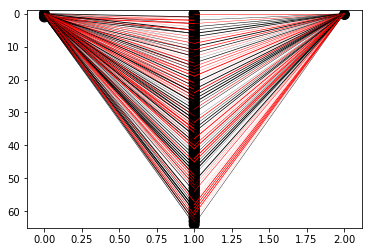

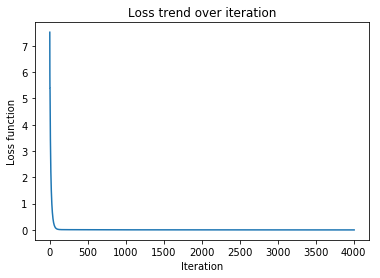

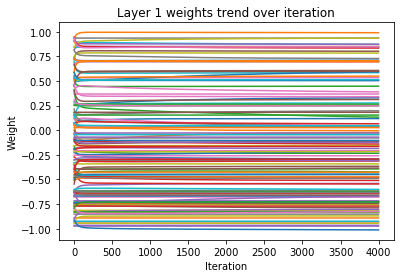

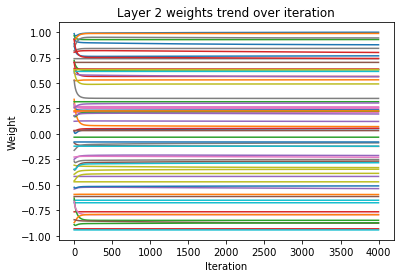

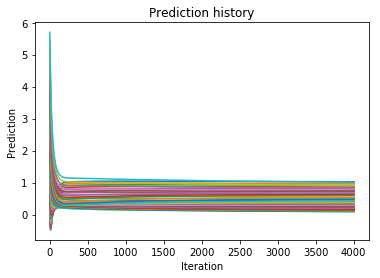

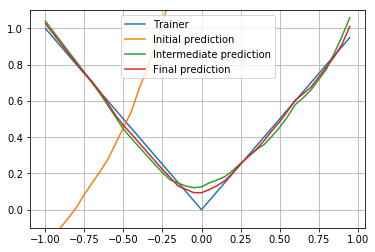

In [205]:

# Plot final trained weights
plotnodes([THETA1,THETA2]);
print(THETA1_hist[0].shape)
# Plot loss function over iterations
plt.figure()
plt.plot(J_hist);
plt.title('Loss trend over iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss function')

plt.figure()
plotWeightHist(THETA1_hist, 1);

plt.figure()
plotWeightHist(THETA2_hist, 2);

plt.figure()
plotArrayHist(h_hist, 'Prediction history', 'Prediction', False);

plt.figure()
plt.plot(trainx, np.array([trainy, h_hist[0], h_hist[len(h_hist)//2], h_hist[-1]]).T.reshape((len(trainx),4)))
#plt.plot(trainx, h_hist[-1].reshape((10,1)))
plt.legend(['Trainer', 'Initial prediction', 'Intermediate prediction', 'Final prediction'])
plt.ylim(-0.1, 1.1)
plt.grid()
